# This Notebook is for analyzing and processing the output of scrap in GCP

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, try to develop a way to improve the search for relevant opportunities in a personalized way for each profile.  


# Libs

In [1]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import gensim
from gensim import corpora

c:\Users\55249\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
import nltk

In [2]:
import pandas_gbq
from google.oauth2 import service_account

from google.cloud import bigquery
%load_ext google.cloud.bigquery

from google.oauth2 import service_account

# Create BigQuery table for save data scraped

In [3]:
credentials = service_account.Credentials.from_service_account_file( 'teste-315517-6ebeb5337f4a.json', )    
pandas_gbq.context.credentials = credentials

In [4]:
project_id = 'teste-315517'
bigquery_client = bigquery.Client(credentials= credentials,project=project_id)

In [6]:
import datetime

In [8]:
now_datetime = datetime.datetime.now()
print(now_datetime)

2023-04-16 17:25:58.476962


In [11]:
schema_scrp=[
    bigquery.SchemaField("title", "STRING"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("company_name", "STRING"),
    bigquery.SchemaField("position_name", "STRING"),
    bigquery.SchemaField("experience_required", "STRING"),
    bigquery.SchemaField("contract_type", "STRING"),
    bigquery.SchemaField("function_name", "STRING"),
    bigquery.SchemaField("company_sector", "STRING"),
    bigquery.SchemaField("description", "STRING"),
    bigquery.SchemaField("link", "STRING"),
    bigquery.SchemaField("now_datetime", "STRING")
]

In [12]:
#criando tabela no bq cpf
table_id = 'teste-315517.teste.raw_from_linkedin'

table = bigquery.Table(table_id, schema=schema_scrp)
table = bigquery_client.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table teste-315517.teste.raw_from_linkedin


# Variables

# Functions

In [5]:
def clean_column_strings(df):
    """Clean each column of a dirty dataframe

    Args:
        df (dataframe): dataframe to be clean

    Returns:
        dataframe: cleaned dataframe
    """
    
    df['location'] = df['location'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_name'] = df['company_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['experience_required'] = df['experience_required'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['contract_type'] = df['contract_type'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['function_name'] = df['function_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_sector'] = df['company_sector'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    clean = re.compile('<.*?>')
    df['description'] = df['description'].apply(lambda x: re.sub(clean, '', x).replace('\n','').strip())
    df['description'] = df['description'].apply(lambda x: word_split(x))
    
    return df

In [6]:
def word_split(text):
    """Split some words that are imprecisaly toguether after scrap

    Args:
        text (string): string to process

    Returns:
        string: string processed
    """
    # replaces each uppercase letter with a space followed by the same lower case letter
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    return text.strip()



In [7]:
def calculate_na_proportion(df):
    """Build a dataframe with some information about null values on the dataframe

    Args:
        df (dataframe): dataframe to calculate

    Returns:
        dataframe: dataframe with null proportions
    """

    # exploratory DF with % NA and types values
    na_proportion = pd.DataFrame({'name' : df.columns, 'type' : df.dtypes,
                            'NA #': df.isna().sum(), 'NA %' : (df.isna().sum() / df.shape[0]) * 100})
    return na_proportion

# Loading data

In [8]:
credentials = service_account.Credentials.from_service_account_file(
    'teste-315517-6ebeb5337f4a.json',
)
pandas_gbq.context.credentials = credentials

sql = """
SELECT 
*
 FROM `teste-315517.teste.raw_from_linkedin`
  """

# Run a Standard SQL query with the project set explicitly
project_id = 'teste-315517'
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

In [9]:
df_raw_bigquery = df.copy()

# Wrangle data experiments

### Clean durty data

In [10]:
df_job = clean_column_strings(df_raw_bigquery)

In [11]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,nan,nan,nan,nan,nan,nan,nan,nan,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947
1,nan,nan,nan,nan,nan,nan,nan,nan,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303
2,nan,nan,nan,nan,nan,nan,nan,nan,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the location Alcoa’s U.S. portfolio incl...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At Big Hat Biosciences our machine l...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148
...,...,...,...,...,...,...,...,...,...,...,...
1685,Field Application Scientist (Remote - Northeast),"San Diego, CA",Bionano,Field Application Scientist (Remote - Northeast),Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Medical Practices,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3625507786,2023-06-08 03:16:26.692885
1686,Associate Director Clinical Research Scientist,"Boston, MA",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630773838,2023-06-08 03:17:30.658174
1687,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630774812,2023-06-08 03:16:48.462292
1688,"Applied Scientist, NLP",United States,Arkestro,"Applied Scientist, NLP",Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Software Development,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3626160737,2023-06-08 03:11:34.818226


# Data job Analysis

In [ ]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [12]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,nan,nan,nan,nan,nan,nan,nan,nan,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947
1,nan,nan,nan,nan,nan,nan,nan,nan,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303
2,nan,nan,nan,nan,nan,nan,nan,nan,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the location Alcoa’s U.S. portfolio incl...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At Big Hat Biosciences our machine l...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148
...,...,...,...,...,...,...,...,...,...,...,...
1685,Field Application Scientist (Remote - Northeast),"San Diego, CA",Bionano,Field Application Scientist (Remote - Northeast),Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Medical Practices,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3625507786,2023-06-08 03:16:26.692885
1686,Associate Director Clinical Research Scientist,"Boston, MA",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630773838,2023-06-08 03:17:30.658174
1687,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630774812,2023-06-08 03:16:48.462292
1688,"Applied Scientist, NLP",United States,Arkestro,"Applied Scientist, NLP",Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Software Development,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3626160737,2023-06-08 03:11:34.818226


In [13]:
key_word_ml = 'learning'
key_word_ds = 'scientist'


# check if a column contain a word
ml_patern = re.compile(rf'\b{re.escape(key_word_ml)}\b', flags=re.IGNORECASE)
ds_patern = re.compile(rf'\b{re.escape(key_word_ds)}\b', flags=re.IGNORECASE)

In [14]:
df_target = df_job.loc[(df_job['position_name'].str.contains(ds_patern)) | (df_job['position_name'].str.contains(ml_patern)) ]

In [18]:
#df_target.to_csv('../data/wrangle/df_target.csv',index=False)

In [15]:
total_number_of_targets_scraped =df_target.count()[0]
total_number_of_targets_scraped

1283

In [16]:
total_number_of_data_scraped = df_job.count()[0]
total_number_of_data_scraped

1690

In [17]:
#proportion of durty data scraped
(total_number_of_data_scraped - total_number_of_targets_scraped) / total_number_of_data_scraped

0.2408284023668639

The targets that have the best matches are in the first positions, but Linkedin sends a lot of unrelated jobs after that that are noncorrelated to the target search

In [18]:
# positions names related with target
df_target

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the location Alcoa’s U.S. portfolio incl...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At Big Hat Biosciences our machine l...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148
5,PK Research Scientist 2 - Remote,United States,Talentify.io,PK Research Scientist 2 - Remote,Mid-Senior level,Full-time,Other,Human Resources Services,Talentify helps candidates around the world to...,https://www.linkedin.com/jobs/view/3572871277,2023-04-16 22:33:27.582860
6,PK Research Scientist 2 - Remote,United States,Talentify.io,PK Research Scientist 2 - Remote,Mid-Senior level,Full-time,Other,Human Resources Services,Talentify helps candidates around the world to...,https://www.linkedin.com/jobs/view/3572871277,2023-04-17 03:08:02.683100
7,Research Scientist - Software Engineering (Rem...,United States,Talentify.io,Research Scientist - Software Engineering (Rem...,Mid-Senior level,Full-time,Other,Human Resources Services,Talentify helps candidates around the world to...,https://www.linkedin.com/jobs/view/3578251554,2023-04-21 03:11:31.082683
...,...,...,...,...,...,...,...,...,...,...,...
1685,Field Application Scientist (Remote - Northeast),"San Diego, CA",Bionano,Field Application Scientist (Remote - Northeast),Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Medical Practices,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3625507786,2023-06-08 03:16:26.692885
1686,Associate Director Clinical Research Scientist,"Boston, MA",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630773838,2023-06-08 03:17:30.658174
1687,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630774812,2023-06-08 03:16:48.462292
1688,"Applied Scientist, NLP",United States,Arkestro,"Applied Scientist, NLP",Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Software Development,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3626160737,2023-06-08 03:11:34.818226


Some of the other position names are related to the target by descriptions. In this case, most of the part are Solution architects, cloud engineers, MLops, Data Analyst, and leads

In [19]:
# descriptions related with targets
df_description_target=df_job.loc[(df_job['description'].str.contains(ds_patern)) | (df_job['description'].str.contains(ml_patern)) ]
df_description_target.count()[0]

1450

In [20]:
#cases that don't have target search (Data Scientist and Machine Learning) in position name but have in descriptions
df_description_target[~df_description_target.index.isin(df_target.index)]


,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,nan,nan,nan,nan,nan,nan,nan,nan,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947
1,nan,nan,nan,nan,nan,nan,nan,nan,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303
2,nan,nan,nan,nan,nan,nan,nan,nan,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566
42,Senior QA/Test Automation Engineer,"San Francisco, CA",Patterned Learning AI,Senior QA/Test Automation Engineer,Mid-Senior level,Full-time,Quality Assurance,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572907289,2023-04-16 21:05:57.514305
43,Senior QA/Test Automation Engineer,"San Francisco, CA",Patterned Learning AI,Senior QA/Test Automation Engineer,Mid-Senior level,Full-time,Quality Assurance,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572907289,2023-04-16 22:35:19.783368
...,...,...,...,...,...,...,...,...,...,...,...
1641,Mid-Level Tableau Developer,"Miami, FL",Patterned Learning AI,Mid-Level Tableau Developer,Mid-Senior level,Full-time,Information Technology,IT Services and IT Consulting,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3630093391,2023-06-08 03:18:24.430290
1642,Senior BI Developer - Remote Opportunity,"Portland, OR",KinderCare Learning Companies,Senior BI Developer - Remote Opportunity,Mid-Senior level,Full-time,Information Technology,Education Management,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3616969826,2023-06-08 03:18:02.894927
1669,Staff Software Engineer,United States,Imagine Learning,Staff Software Engineer,Mid-Senior level,Full-time,Engineering and Information Technology,E-learning,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3629210323,2023-06-07 03:18:55.542520
1672,Senior WordPress Engineer,"Houston, TX",Patterned Learning AI,Senior WordPress Engineer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"<div class=""show-more-less-html__markup show-m...",https://www.linkedin.com/jobs/view/3628803392,2023-06-07 03:17:19.363936


In [21]:
df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)

title
Machine Learning Engineer - NLP - Freelance [Remote]                                    99
Senior Data Scientist                                                                   72
Senior Machine Learning Engineer                                                        69
Senior Data Scientist- Insights, Data Engineering, and Analytics (IDEAs)                55
Senior Machine Learning Engineer, Gigster Network                                       45
Principal Investigator (Data Scientist / Data Science Engineer) - Freelance [Remote]    27
Lead, Data Scientist Regulatory Intelligence and Policy Research (REMOTE)               25
Lead Data Scientist, Credit Card                                                        23
Fellow Software Engineer - Data Scientist                                               20
Data Scientist                                                                          16
Name: position_name, dtype: int64

Top 10 Titles offered  
High diversity title job for the same position

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Machine Learning Engineer - NLP - Freelance [Remote]'),
  Text(1, 0, 'Senior Data Scientist'),
  Text(2, 0, 'Senior Machine Learning Engineer'),
  Text(3, 0, 'Senior Data Scientist- Insights, Data Engineering, and Analytics (IDEAs)'),
  Text(4, 0, 'Senior Machine Learning Engineer, Gigster Network'),
  Text(5, 0, 'Principal Investigator (Data Scientist / Data Science Engineer) - Freelance [Remote]'),
  Text(6, 0, 'Lead, Data Scientist Regulatory Intelligence and Policy Research (REMOTE)'),
  Text(7, 0, 'Lead Data Scientist, Credit Card'),
  Text(8, 0, 'Fellow Software Engineer - Data Scientist'),
  Text(9, 0, 'Data Scientist')])

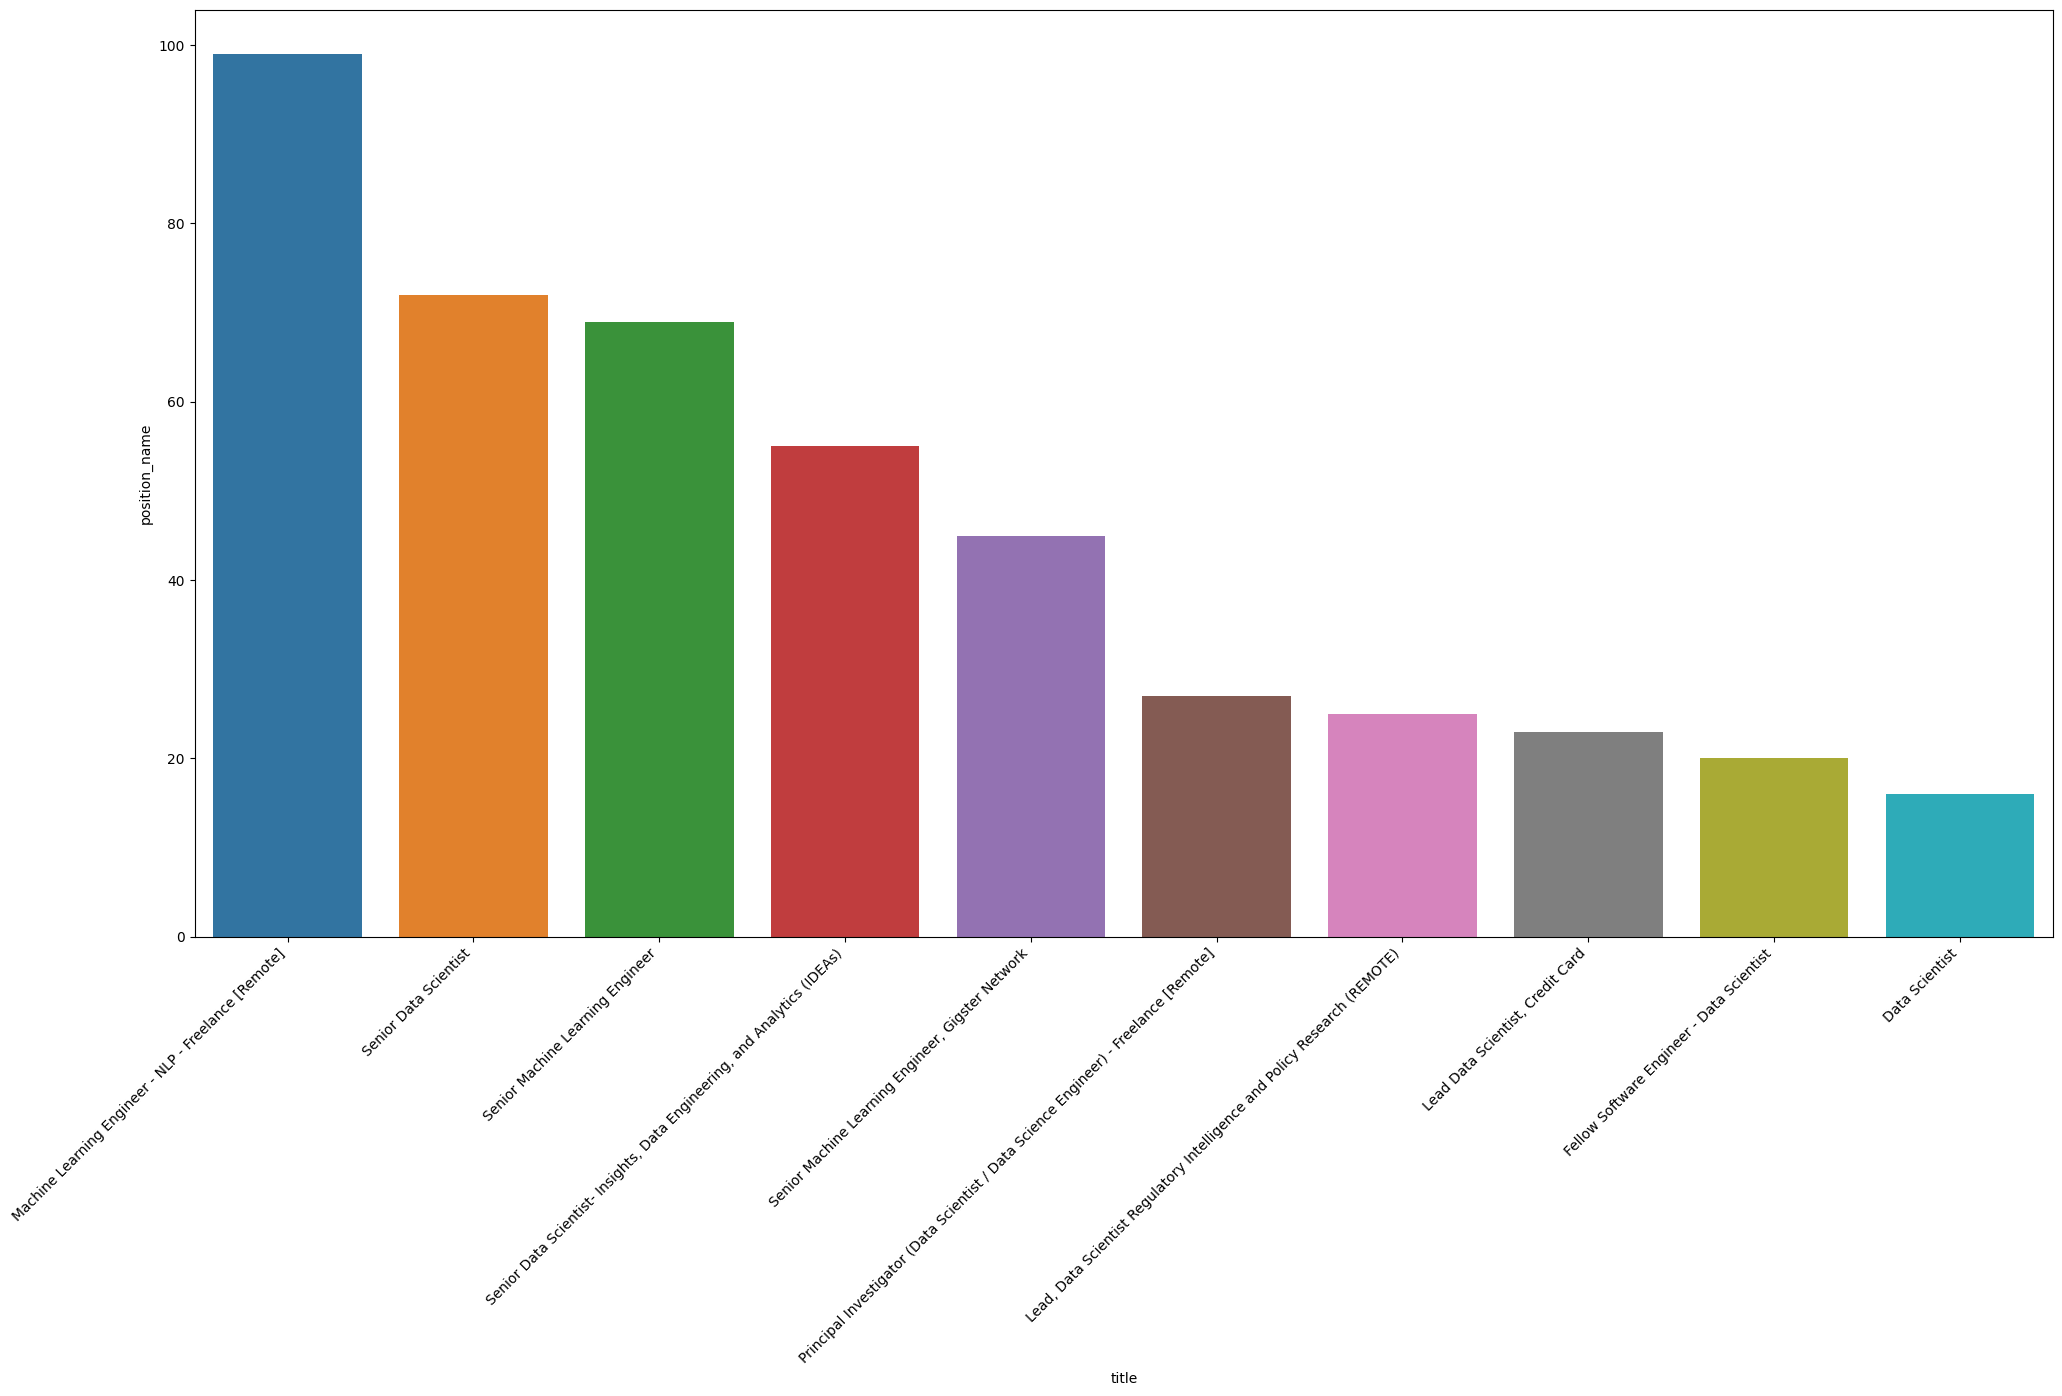

In [22]:
top_10_jobs_name = df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

Experiences required

In [23]:
df_target.groupby('experience_required').count()['title'].sort_values(ascending=False)

experience_required
Mid-Senior level    1229
Associate             54
Name: title, dtype: int64

All contract type

In [24]:
df_target.groupby('contract_type').count()['title'].sort_values(ascending=False)

contract_type
Full-time    1283
Name: title, dtype: int64

All different Function names

In [25]:
df_target.groupby('function_name').count()['title'].sort_values(ascending=False)

function_name
Engineering and Information Technology                              728
Other                                                               171
Research, Analyst, and Information Technology                       102
Information Technology                                               49
Engineering                                                          36
Information Technology and Engineering                               31
Other, Information Technology, and Management                        27
Research                                                             19
Engineering, Information Technology, and Science                     14
Engineering, Information Technology, and Other                        8
Consulting and Marketing                                              8
General Business                                                      7
Sales                                                                 5
Research and Science                              

All different company sectors

In [26]:
df_target.groupby('company_sector').count()['title'].sort_values(ascending=False)

company_sector
Technology, Information and Internet                                                        231
Software Development                                                                        133
Staffing and Recruiting                                                                     100
Human Resources Services                                                                     83
IT Services and IT Consulting, Computer Hardware Manufacturing, and Software Development     72
                                                                                           ... 
Higher Education                                                                              1
Research Services and Insurance                                                               1
Computer Networking Products                                                                  1
Advertising Services, Financial Services, and Business Consulting and Services                1
Online Audio and Video Me

All different locations

In [27]:
df_target.groupby('location').count()['title'].sort_values(ascending=False)

location
United States                    375
San Francisco, CA                 73
New York, NY                      69
Boston, MA                        50
Seattle, WA                       42
                                ... 
Lehi, UT                           1
Los Angeles County, CA             1
Los Angeles Metropolitan Area      1
Louisiana, United States           1
Ypsilanti, MI                      1
Name: title, Length: 222, dtype: int64

Example of description

In [28]:
df_target['description'].iloc[0]

"About the location Alcoa’s U.S. portfolio includes Alcoa's corporate headquarters (ACC), Alcoa's Technology Center (ATC), four smelters, hydroelectric power and a calcined coke plant. Every day is a new and exciting challenge at the Alcoa Technical Center in New Kensington, PA, just north of Pittsburgh; whether working virtually, on-site, or a hybrid of the two, we develop new technologies with our Breakthrough Technologies team that has the potential to impact the life of millions of people, and foster the sustainable footprint from Alcoa to the world. It was here where we developed the technology recently announced in partnership with Rio Tinto, called ELYSIS™, where we will produce aluminum with ZERO emission of greenhouse gases. In fact, we will actually be generating oxygen to our atmosphere during the aluminum production process– a revolution to the aluminum industry!About The Job Alcoa Technical Center (ATC) is the flagship light metal research center of Alcoa situated in New K

In [29]:
df_target['description'].iloc[1]

'The role: At Big Hat Biosciences our machine learning stack is tightly integrated with a high-throughput wetlab to rapidly design and validate ML-engineered antibodies. The Machine Learning Scientist* will work to advance the state of the art at each step in this integrated, iterative antibody optimization platform, improving the effectiveness with which it can be used to design new therapeutics to address unmet patient need.At Big Hat we believe in titles that commensurate with skill set, relative organizational impact, and value contribution; more experienced candidates are encouraged to apply, with the understanding that responsibilities and title would adjust as appropriate. Job Responsibilities Rapidly design, implement, and evaluate predictive machine learning models of diverse antibody biophysical properties, for dataset scales from hundreds to millions, to support Big Hat’s therapeutic portfolio.Develop and implement improved active learning / bayesian optimization methodologi

# Data Science

## Feature engineer

In [25]:
# Create a list of text documents from the dataframe column
texts = df_target['description'].tolist()

# Tokenize the text and remove stop words
texts = [[token for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS] for text in texts]

# Create a dictionary from the data
dictionary = corpora.Dictionary(texts)

# Convert corpus to bag of words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=5,
                                            random_state=42,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# Print top 5 topics with their corresponding top 5 words
topics = lda_model.print_topics(num_topics=5, num_words=5)
for topic in topics:
    print(topic)

(0, '0.030*"data" + 0.026*"work" + 0.026*"models" + 0.022*"upwork" + 0.019*"team"')
(1, '0.040*"data" + 0.017*"experience" + 0.012*"business" + 0.009*"science" + 0.008*"learning"')
(2, '0.011*"ml" + 0.007*"experience" + 0.007*"engineer" + 0.007*"maxonic" + 0.005*"client"')
(3, '0.037*"data" + 0.022*"experience" + 0.011*"years" + 0.010*"scientist" + 0.009*"analysis"')
(4, '0.026*"experience" + 0.025*"data" + 0.020*"learning" + 0.015*"machine" + 0.010*"models"')


### Create a new column that have all words without stop words

In [26]:
df_target['all_words_clean'] = texts

In [27]:
df_target.head()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,all_words_clean
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job Description Summary:The Enterprise Data Sc...,https://www.linkedin.com/jobs/view/3478366331,"[job, description, summary, enterprise, data, ..."
1,100% Remote - Sr. Data Scientist / Data Engine...,United States,Dice,100% Remote - Sr. Data Scientist / Data Engine...,Mid-Senior level,Contract,Engineering and Information Technology,"Technology, Information and Internet",Dice is the leading career destination for tec...,https://www.linkedin.com/jobs/view/3478375375,"[dice, leading, career, destination, tech, exp..."
2,Sr Machine Learning Engineer,United States,Burtch Works,Sr Machine Learning Engineer,Mid-Senior level,Contract,Engineering,Software Development,Senior Machine Learning Engineer As a Senior M...,https://www.linkedin.com/jobs/view/3184133160,"[senior, machine, learning, engineer, senior, ..."
3,Sr. Data Scientist,United States,Insight Global,Sr. Data Scientist,Mid-Senior level,Contract,Information Technology,Broadcast Media Production and Distribution an...,Position: Sr. Data Scientist Duration: 12 mon...,https://www.linkedin.com/jobs/view/3472342299,"[position, sr, data, scientist, duration, mont..."
4,Senior Machine Learning Engineer,"New York, United States",InterEx Group,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Senior Role The ideal candidate's favourite wo...,https://www.linkedin.com/jobs/view/3476849156,"[senior, role, ideal, candidate, favourite, wo..."


## Extract years of experience required in description

### Using regex

In [28]:

# Define regular expression pattern to match the number of years
pattern = r'(\d+)\+?\s*(years|year|yrs|yr)'
matches = df_target['description'].apply(lambda x: re.findall(pattern, x, re.IGNORECASE))

In [29]:
matches

0                                                    []
1                              [(1, Year), (10, years)]
2                                          [(5, years)]
3                                          [(5, years)]
4                                          [(4, years)]
5                              [(6, years), (6, years)]
6                                          [(5, years)]
7                                          [(3, years)]
8     [(10, years), (4, years), (10, year), (3, year...
9                                          [(2, years)]
10                 [(5, years), (5, years), (5, years)]
11                                         [(2, years)]
12                                         [(4, years)]
13                                         [(8, years)]
14    [(31, years), (2, years), (7, years), (7, year...
15                             [(3, years), (5, years)]
16                                                   []
17                                              

In [30]:
# Extract the matched numbers and convert them to integers
matches.apply(lambda x: [int(match[0]) for match in x])

0                                    []
1                               [1, 10]
2                                   [5]
3                                   [5]
4                                   [4]
5                                [6, 6]
6                                   [5]
7                                   [3]
8                     [10, 4, 10, 3, 2]
9                                   [2]
10                            [5, 5, 5]
11                                  [2]
12                                  [4]
13                                  [8]
14            [31, 2, 7, 7, 7, 7, 3, 3]
15                               [3, 5]
16                                   []
17                                   []
18                                   []
19                                   []
20                                  [5]
21                                   []
22                                  [5]
23    [4, 5, 5, 7, 5, 3, 3, 5, 5, 5, 5]
24                                   []


In [32]:
df_target['description'][47]

'Volitiion IIT Inc. is an IT Service and Staffing firm based of Leesburg VA. We have hiring Top Talents to add to our growing team of Technology Professionals.We are looking for a Data Scientist to add to our team.Job Overview Scope of job:Gather relevant data and perform detailed analysis of driver allocation and routing data to develop predictive models for driver assignment, arrival/departure timing, truckload optimization, and route optimization. Work directly with the client to understand desired outcomes and business/technical constraints. Develop analytical models that validate proposed changes to business practices/procedures and participate in the presentation of results to client leadership.Required Work with stakeholders to identify key metrics and opportunities for improving business processes, products, and services Perform data mining, exploration, and analysis Create data visualizations, reports Design, train, and implement machine learning algorithms Leverage predictive

### Using entity recognition model "NLTK"

In [49]:
# Download necessary resources for NER
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


In [77]:
# Sample text to be analyzed
text = df_target['description'][0]

# Tokenize the text
tokens = nltk.word_tokenize(text)

# Perform part-of-speech tagging on the tokens
tagged = nltk.pos_tag(tokens)

# Perform named entity recognition on the tagged tokens
entities = nltk.chunk.ne_chunk(tagged)

# Create an empty DataFrame to store the named entities
df = pd.DataFrame(columns=['Entity', 'Type'])

# Loop over the named entities found in the text and add them to the DataFrame
for entity in entities:
    try:
        ne = ' '.join(c[0] for c in entity.leaves())
        ne_type = entity.label()
        df = pd.concat([df, pd.DataFrame({'Entity': [ne], 'Type': [ne_type]})], ignore_index=True)
    except:
        exit

In [78]:
entities

Trained model NLTK doesn't have good results identifying entities

In [79]:
df

,Entity,Type
0,Job,PERSON
1,Enterprise Data Science,ORGANIZATION
2,Hershey,PERSON
3,Enterprise,ORGANIZATION
4,Hershey,PERSON
5,Hershey,PERSON
6,Data Science,PERSON
7,Data Science Solution Delivery,PERSON
8,Data Science Domain,PERSON
9,Hershey Data Science,ORGANIZATION


### Custom trained NLTK Stanford NER tagger

In [ ]:
# Set the path to the Stanford NER jar and model
stanford_dir = '../data/files/stanford-ner.jar'
model_filename = '../data/files/english.muc.7class.distsim.crf.ser.gz'
jar_filename = '../data/files/stanford-ner.jar/stanford-ner.jar'

In [198]:
import nltk
from nltk.tag.stanford import StanfordNERTagger

sentence = u"Twenty miles east of Reno, Nev., " \
    "where packs of wild mustangs roam free through " \
    "the parched landscape, Tesla Gigafactory 1 " \
    "sprawls near Interstate 80."

jar = '../data/files/stanford-ner.jar/stanford-ner.jar'
model = '../data/files/english.muc.7class.distsim.crf.ser.gz'

# Prepare NER tagger with english model
ner_tagger = StanfordNERTagger(model, jar, encoding='utf8')

# Tokenize: Split sentence into words
words = nltk.word_tokenize(sentence)

# Run NER tagger on words
print(ner_tagger.tag(words))

LookupError: 

===========================================================================
NLTK was unable to find the java file!
Use software specific configuration parameters or set the JAVAHOME environment variable.
===========================================================================

In [171]:
import nltk
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

In [182]:
from nltk.tag import CRFTagger

In [191]:
import pycrfsuite

In [186]:
# Initialize the Stanford NER tagger with the jar and model file paths
stanford_tagger = StanfordNERTagger(model_filename, jar_filename)

In [187]:
stanford_tagger

In [189]:
# Define the training data
training_data = [
    ('John Smith is from the United States of America.', [('John', 'PERSON'), ('Smith', 'PERSON'), ('United States of America', 'LOCATION')]),
    ('The Eiffel Tower is in Paris, France.', [('Eiffel Tower', 'LOCATION'), ('Paris', 'LOCATION'), ('France', 'LOCATION')]),
    ('I love eating Italian food.', []),
    ('My favorite movie is Star Wars.', [('Star Wars', 'MOVIE')])
]

In [194]:
# Initialize the CRF tagger
ner_trainer = CRFTagger()

NameError: name 'pycrfsuite' is not defined

In [192]:
# Initialize the CRF tagger
ner_trainer = CRFTagger()

# Train the tagger using the training data
ner_trainer.train(training_data, 'model.crf.tagger')

# Load the trained model
custom_tagger = CRFTagger()
custom_tagger.set_model_file('model.crf.tagger')

# Test the custom tagger on a sample sentence
test_sentence = 'John Smith is from the United States of America.'
tokens = word_tokenize(test_sentence)
tagged = custom_tagger.tag(tokens)
print(tagged)

NameError: name 'pycrfsuite' is not defined

In [193]:
ner_trainer

NameError: name 'ner_trainer' is not defined

In [195]:
# Train the custom NER tagger
ner_trainer = nltk.tag.CRFTagger()

NameError: name 'pycrfsuite' is not defined

In [183]:


# Train the custom NER tagger
ner_trainer = nltk.tag.CRFTagger()
ner_trainer.train(training_data, 'model.crf.tagger')
custom_tagger = nltk.tag.CRFTagger()
custom_tagger.set_model_file('model.crf.tagger')

# Test the custom NER tagger
test_sentence = 'John Smith is from the United States of America.'
tokens = word_tokenize(test_sentence)
tagged = custom_tagger.tag(tokens)
print(tagged)

NameError: name 'pycrfsuite' is not defined

In [184]:
ner_trainer

NameError: name 'ner_trainer' is not defined

In [ ]:
import nltk
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

# Set the path to the Stanford NER jar and model
stanford_dir = '/path/to/stanford-ner-4.2.0'
model_filename = stanford_dir + '/classifiers/english.muc.7class.distsim.crf.ser.gz'
jar_filename = stanford_dir + '/stanford-ner.jar'

# Initialize the Stanford NER tagger with the jar and model file paths
stanford_tagger = StanfordNERTagger(model_filename, jar_filename)

# Define the training data
training_data = [
    ('John Smith is from the United States of America.', [('John', 'PERSON'), ('Smith', 'PERSON'), ('United States of America', 'LOCATION')]),
    ('The Eiffel Tower is in Paris, France.', [('Eiffel Tower', 'LOCATION'), ('Paris', 'LOCATION'), ('France', 'LOCATION')]),
    ('I love eating Italian food.', []),
    ('My favorite movie is Star Wars.', [('Star Wars', 'MOVIE')])
]

# Train the custom NER tagger
ner_trainer = nltk.tag.CRFTagger()
ner_trainer.train(training_data, 'model.crf.tagger')
custom_tagger = nltk.tag.CRFTagger()
custom_tagger.set_model_file('model.crf.tagger')

# Test the custom NER tagger
test_sentence = 'John Smith is from the United States of America.'
tokens = word_tokenize(test_sentence)
tagged = custom_tagger.tag(tokens)
print(tagged)


### Train personalized model to entity recognition from zero

In [81]:
import random
import pickle


In [82]:
# Define a function to extract features from the input
def job_features(text):
    features = {}
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    for word, pos in tagged:
        features['word({})'.format(word.lower())] = True
        features['pos({})'.format(pos)] = True
    return features

In [90]:
df_target['description'][0]

"Job Description Summary:The Enterprise Data Science organization drives value for Hershey by creating disruptive predictive and prescriptive solutions to the Enterprise for analytics and decision-making.The Sr. Data Scientist will be working with Hershey business partners, technical engineers, data architects, and project managers to ensure data science standards adhere to company best practice and help to deliver rapid impactful benefits.The Sr. Data Scientist will act as a trusted advisor for Hershey business partners to build new, data-driven, machine-intelligent capabilities that impact the business. You will work with large volumes of data, innovative technologies, and advanced methods to solve real business problems. You'll design and run experiments, research new algorithms, and find new ways of optimizing risk, profitability, and the customer experience. You will work with a diverse team of business analysts, technical engineers, data architects, and project managers to delive

In [92]:
# Define the job description dataset
job_dataset = [
    ("deep learning", "skills"), ("Keras", "skills"), ("Tensor Flow", "skills"), ("Py Torch", "skills"), ("Scikit-learn", "skills"), ("Spark", "skills"), ("SQL", "skills"), ("Hadoop", "skills"), ("AWS", "skills"), ("Azure", "skills"), ("Google Cloud", "skills"), ("GCP", "skills"),
    ("CNN", "skills"),("GAN", "skills"),("LSTM", "skills"),("RNN", "skills") ,("XGBOOST", "skills") ,("Snowflake", "skills") ,("Databricks ", "skills") ,("AI-platform", "skills") ,("Ability to communicate complex ideas in a clear, precise, and actionable manner", "skills") ,
    ("Excellent communication and presentation skills", "skills") ,("ability to articulate new ideas and concepts to technical and non-technical partners", "skills")                 
               
               
               ]

# Add more job descriptions to the dataset
job_dataset += [("Masters In a STEM Degree Required", "skills"), 
                ("Ph.D. Preferred Minimum Experience Requirements", "skills")]

# Shuffle the dataset
random.shuffle(job_dataset)

# Create feature sets for the dataset using the job_features function
feature_sets = [(job_features(job), label) for (job, label) in job_dataset]

# Split the dataset into training and testing sets
train_set, test_set = feature_sets[3:], feature_sets[:3]

In [93]:
# Train the Naive Bayes classifier using the training set
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [103]:
# Save the trained classifier to a file
model_file = '../data/files/personalized_classifier.pickle'
with open(model_file, 'wb') as f:
    pickle.dump(classifier, f)

In [94]:
# Evaluate the accuracy of the classifier on the testing set
accuracy = nltk.classify.accuracy(classifier, test_set)
print('Accuracy:', accuracy)

Accuracy: 1.0


Predict new data with trained model

In [104]:
# Load the trained NLTK model
model_file = '../data/files/personalized_classifier.pickle'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

In [118]:
text = df_target['description'][1]

In [162]:

# Load the new dataframe with job descriptions
df = df_target

# Define a function to identify job descriptions in the dataframe
def identify_job_descriptions(df):
    # Loop through each row in the dataframe
    for i, row in df.iterrows():
        # Tokenize the job description and use the trained model to identify each word
        job_tokens = nltk.word_tokenize(row['description'])
        job_features = [dict([(feature, True)]) for feature in job_tokens]
        job_labels = model.classify_many(job_features)

        # Create a new column with the identified entities for each word
        df.at[i, 'extracted_person_entities'] = str(list(zip(job_tokens, job_labels)))

    return df

# Call the function with the new dataframe
df = identify_job_descriptions(df)

# Print the resulting dataframe
print(df)

                                                title  \
0                                  Sr. Data Scientist   
1   100% Remote - Sr. Data Scientist / Data Engine...   
2                        Sr Machine Learning Engineer   
3                                  Sr. Data Scientist   
4                    Senior Machine Learning Engineer   
5                                 Lead Data Scientist   
6                    Senior Machine Learning Engineer   
7                       Machine Learning Ops Engineer   
8                    Senior Machine Learning Engineer   
9                                   Sr Data Scientist   
10                                     Data Scientist   
11                Data Scientist - Customer Analytics   
12                          Machine Learning Engineer   
13                            Azure ML/Data Scientist   
14                                     Data Scientist   
15                                     Data Scientist   
16                             

In [170]:
df

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,all_words_clean,extracted_person_entities
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job Description Summary:The Enterprise Data Sc...,https://www.linkedin.com/jobs/view/3478366331,"[job, description, summary, enterprise, data, ...","[('Job', 'skills'), ('Description', 'skills'),..."
1,100% Remote - Sr. Data Scientist / Data Engine...,United States,Dice,100% Remote - Sr. Data Scientist / Data Engine...,Mid-Senior level,Contract,Engineering and Information Technology,"Technology, Information and Internet",Dice is the leading career destination for tec...,https://www.linkedin.com/jobs/view/3478375375,"[dice, leading, career, destination, tech, exp...","[('Dice', 'skills'), ('is', 'skills'), ('the',..."
2,Sr Machine Learning Engineer,United States,Burtch Works,Sr Machine Learning Engineer,Mid-Senior level,Contract,Engineering,Software Development,Senior Machine Learning Engineer As a Senior M...,https://www.linkedin.com/jobs/view/3184133160,"[senior, machine, learning, engineer, senior, ...","[('Senior', 'skills'), ('Machine', 'skills'), ..."
3,Sr. Data Scientist,United States,Insight Global,Sr. Data Scientist,Mid-Senior level,Contract,Information Technology,Broadcast Media Production and Distribution an...,Position: Sr. Data Scientist Duration: 12 mon...,https://www.linkedin.com/jobs/view/3472342299,"[position, sr, data, scientist, duration, mont...","[('Position', 'skills'), (':', 'skills'), ('Sr..."
4,Senior Machine Learning Engineer,"New York, United States",InterEx Group,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Senior Role The ideal candidate's favourite wo...,https://www.linkedin.com/jobs/view/3476849156,"[senior, role, ideal, candidate, favourite, wo...","[('Senior', 'skills'), ('Role', 'skills'), ('T..."
5,Lead Data Scientist,United States,Revolution Technologies,Lead Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Rev Up Your Career as a Data Scientist Job Tit...,https://www.linkedin.com/jobs/view/3475123003,"[rev, career, data, scientist, job, title, lea...","[('Rev', 'skills'), ('Up', 'skills'), ('Your',..."
6,Senior Machine Learning Engineer,"New York, NY",Burtch Works,Senior Machine Learning Engineer,Mid-Senior level,Contract,"Information Technology, Engineering, and Research","IT Services and IT Consulting, Software Develo...",Job Description: Senior Machine Learning Engi...,https://www.linkedin.com/jobs/view/3472314248,"[job, description, senior, machine, learning, ...","[('Job', 'skills'), ('Description', 'skills'),..."
7,Machine Learning Ops Engineer,"Austin, TX",Wimmer Solutions,Machine Learning Ops Engineer,Mid-Senior level,Contract,Information Technology,Machinery Manufacturing,Machine Learning Ops Engineer- Remote Client L...,https://www.linkedin.com/jobs/view/3348098378,"[machine, learning, ops, engineer, remote, cli...","[('Machine', 'skills'), ('Learning', 'skills')..."
8,Senior Machine Learning Engineer,"Durham, NC",Vector Technologies LLC,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Financial Services,Title: Senior Machine Learning Engineer Locati...,https://www.linkedin.com/jobs/view/3473341847,"[title, senior, machine, learning, engineer, l...","[('Title', 'skills'), (':', 'skills'), ('Senio..."
9,Sr Data Scientist,"New York, United States",InterEx Group,Sr Data Scientist,Mid-Senior level,Contract,Information Technology and Engineering,Staffing and Recruiting,"My client are a Global Retail Brand, with over...",https://www.linkedin.com/jobs/view/3431317441,"[client, global, retail, brand, employees, shy...","[('My', 'skills'), ('client', 'skills'), ('are..."


In [167]:
df['extracted_person_entities'][0]

'[(\'Job\', \'skills\'), (\'Description\', \'skills\'), (\'Summary\', \'skills\'), (\':\', \'skills\'), (\'The\', \'skills\'), (\'Enterprise\', \'skills\'), (\'Data\', \'skills\'), (\'Science\', \'skills\'), (\'organization\', \'skills\'), (\'drives\', \'skills\'), (\'value\', \'skills\'), (\'for\', \'skills\'), (\'Hershey\', \'skills\'), (\'by\', \'skills\'), (\'creating\', \'skills\'), (\'disruptive\', \'skills\'), (\'predictive\', \'skills\'), (\'and\', \'skills\'), (\'prescriptive\', \'skills\'), (\'solutions\', \'skills\'), (\'to\', \'skills\'), (\'the\', \'skills\'), (\'Enterprise\', \'skills\'), (\'for\', \'skills\'), (\'analytics\', \'skills\'), (\'and\', \'skills\'), (\'decision-making.The\', \'skills\'), (\'Sr.\', \'skills\'), (\'Data\', \'skills\'), (\'Scientist\', \'skills\'), (\'will\', \'skills\'), (\'be\', \'skills\'), (\'working\', \'skills\'), (\'with\', \'skills\'), (\'Hershey\', \'skills\'), (\'business\', \'skills\'), (\'partners\', \'skills\'), (\',\', \'skills\'),

### Using entity recognition model "Spacy"

In [14]:
import spacy
import random

In [15]:
df_target.head()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job Description Summary:The Enterprise Data Sc...,https://www.linkedin.com/jobs/view/3478366331
1,100% Remote - Sr. Data Scientist / Data Engine...,United States,Dice,100% Remote - Sr. Data Scientist / Data Engine...,Mid-Senior level,Contract,Engineering and Information Technology,"Technology, Information and Internet",Dice is the leading career destination for tec...,https://www.linkedin.com/jobs/view/3478375375
2,Sr Machine Learning Engineer,United States,Burtch Works,Sr Machine Learning Engineer,Mid-Senior level,Contract,Engineering,Software Development,Senior Machine Learning Engineer As a Senior M...,https://www.linkedin.com/jobs/view/3184133160
3,Sr. Data Scientist,United States,Insight Global,Sr. Data Scientist,Mid-Senior level,Contract,Information Technology,Broadcast Media Production and Distribution an...,Position: Sr. Data Scientist Duration: 12 mon...,https://www.linkedin.com/jobs/view/3472342299
4,Senior Machine Learning Engineer,"New York, United States",InterEx Group,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Senior Role The ideal candidate's favourite wo...,https://www.linkedin.com/jobs/view/3476849156


In [19]:
# Criar um objeto de linguagem
nlp = spacy.load("en_core_web_sm")

In [20]:
nlp

In [24]:
# Criar um conjunto de dados de treinamento com exemplos anotados
TRAIN_DATA = [
    ("O Google foi fundado por Larry Page e Sergey Brin.", {"entities": [(0, 6, "TST"), (24, 33, "PER"), (38, 49, "PER")]}),
    ("A sede da Microsoft fica em Redmond.", {"entities": [(10, 19, "TST"), (28, 35, "LOC")]})
]

In [25]:
# Adicionar uma nova entidade ao componente NER existente
ner = nlp.get_pipe("ner")
ner.add_label("TST")

1

In [26]:
ner

In [29]:
from spacy.util import minibatch
from spacy.util import compounding
# Treinar o modelo usando um loop de treinamento
for epoch in range(10):
    # Embaralhar os dados de treinamento
    spacy.util.fix_random_seed(epoch)
    random.shuffle(TRAIN_DATA)
    losses = {}
    
    # Criar lotes dos dados de treinamento usando o minibatch do spaCy
    batches = minibatch(TRAIN_DATA, size=compounding(1.0, 4.0, 1.001))
    
    # Atualizar o modelo para cada lote
    for batch in batches:
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]
        nlp.update(texts, annotations, losses=losses)
    
    # Imprimir as perdas a cada época
    print(f"Losses at epoch {epoch} - {losses}")

ValueError: [E989] `nlp.update()` was called with two positional arguments. This may be due to a backwards-incompatible change to the format of the training data in spaCy 3.0 onwards. The 'update' function should now be called with a batch of Example objects, instead of `(text, annotation)` tuples. 

In [ ]:


# Salvar e testar o modelo treinado
nlp.to_disk("/model")

nlp_test = spacy.load("/model")
doc_test = nlp_test("A Apple é uma empresa fundada por Steve Jobs.")
print("Entities", [(ent.text, ent.label_) for ent in doc_test.ents])

In [16]:
sentence = "I want to book a flight to Paris"
entity = "Paris"

start_index = sentence.find(entity)
end_index = start_index + len(entity)

print(start_index, end_index)

27 32


In [17]:
ner

NameError: name 'ner' is not defined

In [1]:
import spacy
import random
from spacy.util import minibatch, compounding

# Define the training data
TRAIN_DATA = [
    ("I want to book a flight to Paris", {"entities": [(25, 30, "GPE")]}),
    ("Can you help me find a hotel in Berlin?", {"entities": [(28, 34, "GPE")]}),
    ("I'm looking for a restaurant in Rome", {"entities": [(30, 34, "GPE")]}),
    ("I'm flying to London next week", {"entities": [(15, 21, "GPE")]}),
    ("I'll be in New York for the weekend", {"entities": [(13, 21, "GPE")]}),
    ("I want to rent a car in San Francisco", {"entities": [(28, 41, "GPE")]}),
]

# Define the entity labels
LABELS = ["GPE"]

# Load the pre-trained model and add the entity recognizer to the pipeline
nlp = spacy.load("en_core_web_sm")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)
#nlp.add_pipe('ner')

# Add the entity labels to the model
for label in LABELS:
    ner.add_label(label)

# Disable other pipeline components that are not needed for training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    # Initialize the model weights
    optimizer = nlp.begin_training()

    # Train the model for 10 iterations
    for i in range(10):
        # Shuffle the training data
        random.shuffle(TRAIN_DATA)

        # Create batches of training data
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))

        # Iterate through the batches
        for batch in batches:
            # Extract the text and annotations for each sample in the batch
            texts, annotations = zip(*batch)

            # Update the model with the batch
            nlp.update(texts, annotations, sgd=optimizer)

# Test the model on some example text
doc = nlp("I'm planning a trip to Amsterdam")
print("Entities:", [(ent.text, ent.label_) for ent in doc.ents])


c:\Users\55249\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
C:\Users\55249\AppData\Roaming\Python\Python39\site-packages\spacy\util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


ValueError: [E966] `nlp.add_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <spacy.pipeline.ner.EntityRecognizer object at 0x000001AD5B3CE040> (name: 'None').

- If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.add_pipe` with the string name instead, e.g. `nlp.add_pipe('textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.add_pipe('your_name')` to add it to the pipeline.

In [47]:
# Define the training data
TRAIN_DATA = [
    ("I want to order a pizza from Pizza Palace", {"entities": [(23, 35, "RESTAURANT")]}),
    ("Get me a burger from Burger Queen", {"entities": [(15, 25, "RESTAURANT")]}),
    ("I'm craving sushi from Sushi Spot", {"entities": [(20, 31, "RESTAURANT")]}),
    ("I want a sandwich from Submarine Sandwiches", {"entities": [(16, 38, "RESTAURANT")]}),
    ("Order me a coffee from Starbucks", {"entities": [(19, 28, "RESTAURANT")]}),
    ("I want a burger and fries from McDonald's", {"entities": [(20, 30, "RESTAURANT")]}),
    ("Get me a burrito from Chipotle", {"entities": [(14, 22, "RESTAURANT")]}),
    ("I'm in the mood for pizza from Papa John's", {"entities": [(24, 35, "RESTAURANT")]}),
]

# Define the function to train the model
def train_model(nlp, train_data, n_iter=100):
    # Create a new entity recognizer
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        #nlp.add_pipe(ner, last=True)
        #nlp.add_pipe('ner')
    else:
        ner = nlp.get_pipe("ner")
    
    # Add the new label to the entity recognizer
    ner.add_label("RESTAURANT")
    
    # Disable other pipeline components during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        # Initialize the optimizer
        optimizer = nlp.begin_training()
        for i in range(n_iter):
            # Shuffle the training data for each iteration
            random.shuffle(train_data)
            losses = {}
            for text, annotations in train_data:
                # Update the model with each text-annotation pair
                nlp.update([text], [annotations], sgd=optimizer, losses=losses)
            print(f"Iteration {i+1}: Losses = {losses}")
    
    return nlp

# Train the model
nlp = spacy.blank("en")
nlp = train_model(nlp, TRAIN_DATA)

# Test the model on some example text
text = "I want to order a pizza from Pizza Hut"
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)


ValueError: [E989] `nlp.update()` was called with two positional arguments. This may be due to a backwards-incompatible change to the format of the training data in spaCy 3.0 onwards. The 'update' function should now be called with a batch of Example objects, instead of `(text, annotation)` tuples. 

### Next - create a model for classify the opportunities